# K-Nearest Neighbors Regression: From scikit-learn on the California Housing Dataset
This notebook demonstrates regression with K-Nearest Neighbors (KNN):

- Load and explore the California Housing dataset
- Visualize two features against the target
- Evaluate model performance (MSE, MAE, R²)
- Use scikit-learn's `KNeighborsRegressor` with default and tuned parameters
- Perform hyperparameter tuning via cross-validation
- Plot validation curves and predicted vs. actual scatter

Formulas, detailed explanations, and a final discussion are provided.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
sns.set_theme()


## Data Loading & Exploration
Fetch the California Housing dataset and inspect its shape and feature names.

In [12]:
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='MedHouseValue')  # median house value in $100k
print(f"Feature matrix shape: {X.shape}")
print("Features:", list(X.columns))
print("Target stats:\n", y.describe())

Feature matrix shape: (20640, 8)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target stats:
 count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: MedHouseValue, dtype: float64


In [13]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


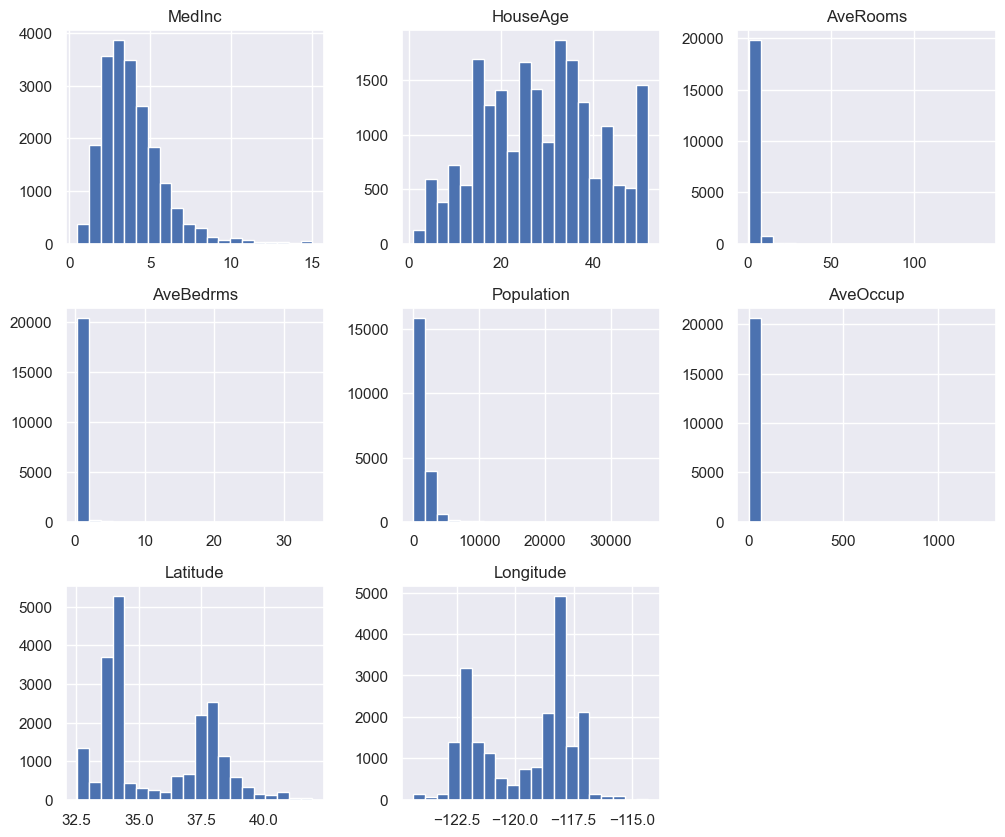

In [14]:
X.describe()
X.hist(figsize=(12, 10), bins=20)
plt.show()

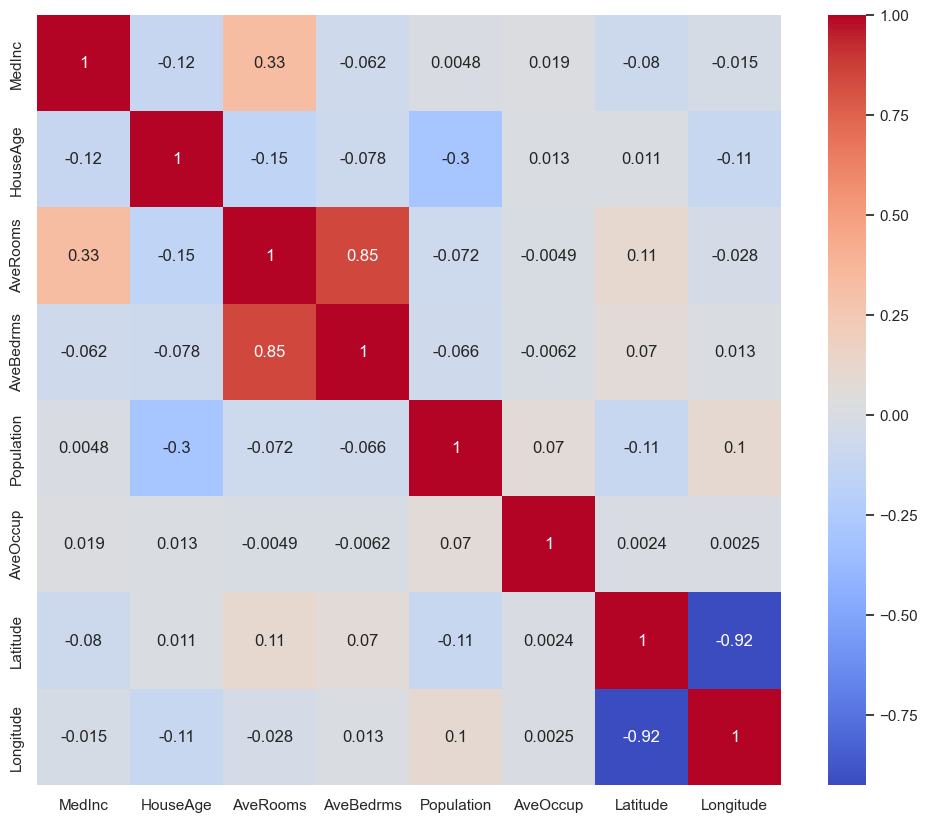

In [15]:
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.show()

## Visualizing Two Features vs Target
Scatter plots of **MedInc** and **AveOccup** against the median house value.

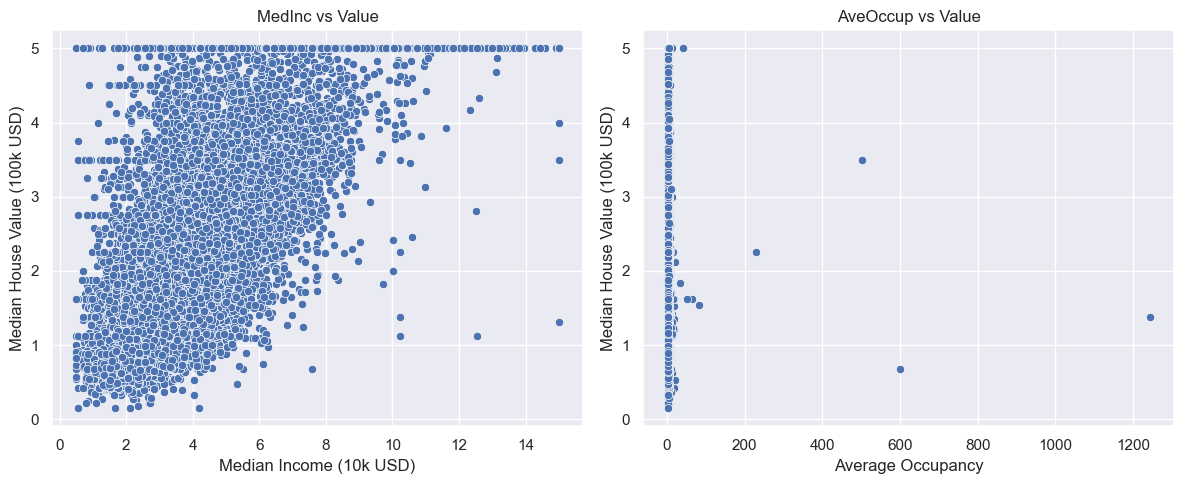

In [16]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x=X['MedInc'], y=y)
plt.xlabel('Median Income (10k USD)')
plt.ylabel('Median House Value (100k USD)')
plt.title('MedInc vs Value')
plt.subplot(1,2,2)
sns.scatterplot(x=X['AveOccup'], y=y)
plt.xlabel('Average Occupancy')
plt.ylabel('Median House Value (100k USD)')
plt.title('AveOccup vs Value')
plt.tight_layout()
plt.show()

## Preprocessing
1. **Standardize** features:
$$X_{\mathrm{std}} = \frac{X - \mu}{\sigma}$$
2. **Train/Test split** (80% train, 20% test) with random state for reproducibility.

In [17]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_std, y, test_size=0.2, random_state=42
)
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

Training samples: 16512, Test samples: 4128


## scikit-learn KNN Regression
Use `KNeighborsRegressor` with default parameters (k=5, uniform weights).

In [18]:
knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train, y_train)
y_pred_sk = knn_reg.predict(X_test)
mse_sk = mean_squared_error(y_test, y_pred_sk)
mae_sk = mean_absolute_error(y_test, y_pred_sk)
r2_sk  = r2_score(y_test, y_pred_sk)
print(f"scikit-learn KNN Regression:")
print(f" MSE = {mse_sk:.3f}, MAE = {mae_sk:.3f}, R² = {r2_sk:.3f}")

scikit-learn KNN Regression:
 MSE = 0.434, MAE = 0.446, R² = 0.669


## Predicted vs Actual
Scatter plot comparing predictions to true values.

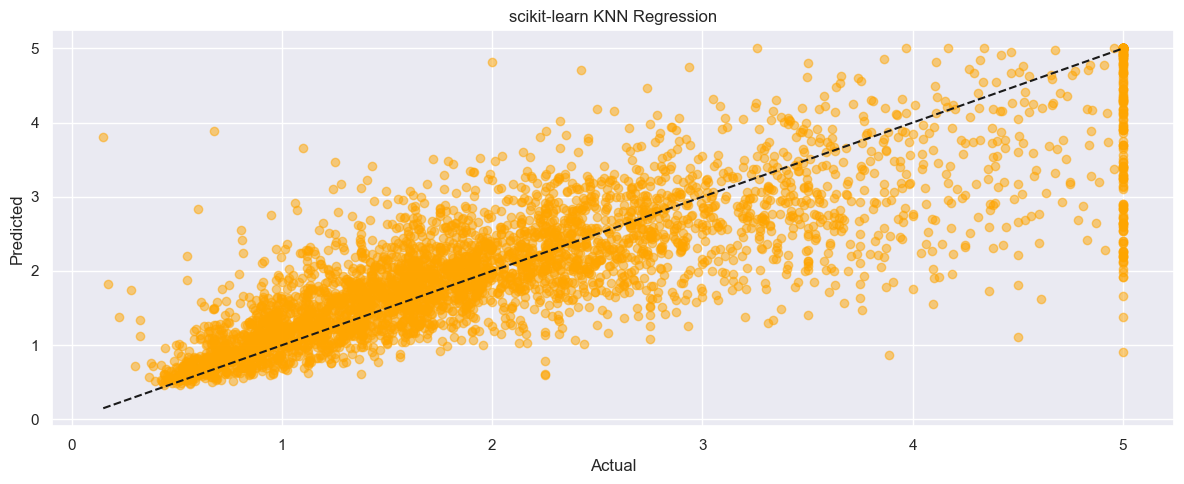

In [19]:
plt.figure(figsize=(12,5))
plt.scatter(y_test, y_pred_sk, alpha=0.5, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('scikit-learn KNN Regression')
plt.tight_layout()
plt.show()

## Error Distribution
Histogram of residuals (prediction errors) for the scikit-learn model.

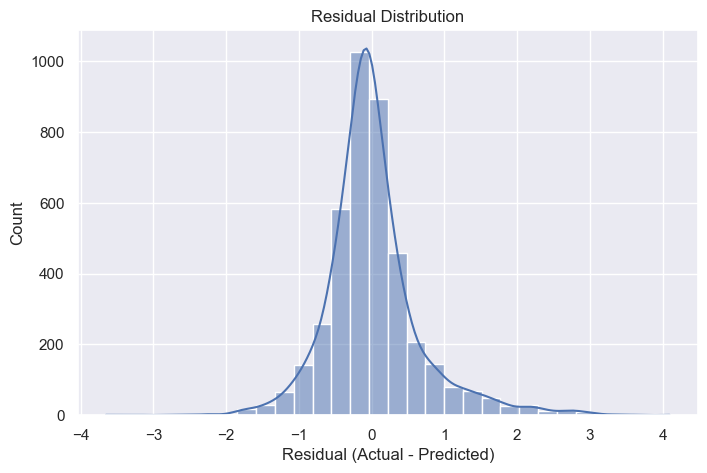

In [20]:
residuals = y_test - y_pred_sk
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel('Residual (Actual - Predicted)')
plt.title('Residual Distribution')
plt.show()

## Prediction Surface Visualization

Using **MedInc** (median income) and **AveOccup** (average occupancy) as our two features, we train a fresh `KNeighborsRegressor` on just those dimensions, then plot the continuous prediction “surface” over a 2D grid. Actual test points are overlaid and colored by their true median‐house‐value.


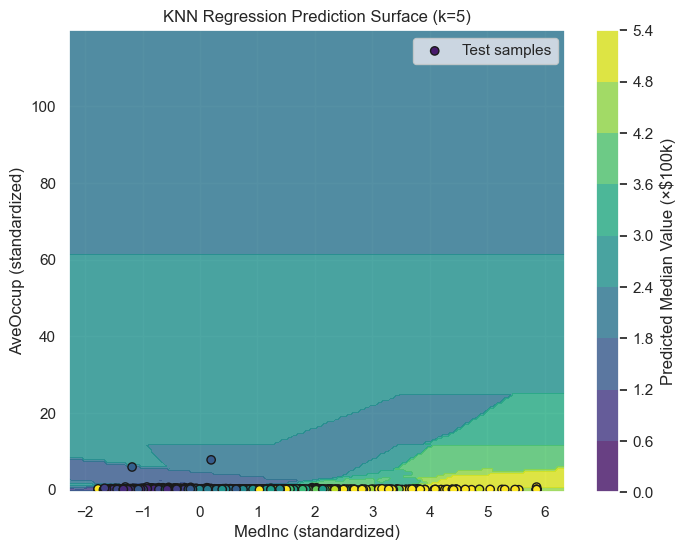

In [25]:
# 1) Select the two features (MedInc=index 0, AveOccup=index 5)
X2_train = X_train[:, [0, 5]]
X2_test  = X_test[:,  [0, 5]]

# 2) Fit on 2D data
knn2 = KNeighborsRegressor(n_neighbors=5, weights='uniform')
knn2.fit(X2_train, y_train)

# 3) Build a meshgrid over the feature ranges
xx, yy = np.meshgrid(
    np.linspace(X2_train[:,0].min()-0.5, X2_train[:,0].max()+0.5, 200),
    np.linspace(X2_train[:,1].min()-0.5, X2_train[:,1].max()+0.5, 200)
)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# 4) Predict on every grid point
Z = knn2.predict(grid_points).reshape(xx.shape)

# 5) Plot the surface + test points
plt.figure(figsize=(8,6))
cf = plt.contourf(xx, yy, Z, cmap='viridis', alpha=0.8)
plt.colorbar(cf, label='Predicted Median Value (×$100k)')
plt.scatter(
    X2_test[:,0], X2_test[:,1],
    c=y_test, cmap='viridis',
    edgecolor='k', label='Test samples'
)
plt.xlabel('MedInc (standardized)')
plt.ylabel('AveOccup (standardized)')
plt.title('KNN Regression Prediction Surface (k=5)')
plt.legend()
plt.show()


## Regression Error vs. \(k\)

We compute the **test‐set MSE** for a range of odd values of \(k\) and plot it to see the bias–variance trade‐off.


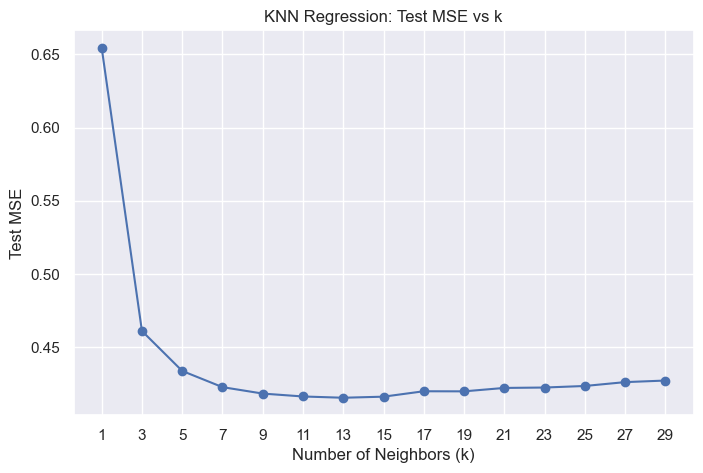

In [26]:
ks = list(range(1, 31, 2))
mse_scores = []

for k in ks:
    model = KNeighborsRegressor(n_neighbors=k, weights='uniform')
    model.fit(X_train, y_train)
    y_pred_k = model.predict(X_test)
    mse_scores.append(mean_squared_error(y_test, y_pred_k))

plt.figure(figsize=(8,5))
plt.plot(ks, mse_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Test MSE')
plt.title('KNN Regression: Test MSE vs k')
plt.xticks(ks)
plt.grid(True)
plt.show()


### Conclusions

- **Small \(k\)** (e.g.\ \(k=1\)) yields very low bias but **high variance**, so MSE is relatively large due to noise fitting.  
- **Large \(k\)** oversmooths the data (high bias), also raising MSE.  
- The “sweet spot” on this dataset appears around **\(k=7\)–\(11\)** where test MSE is minimized.  